In [1]:
import pandas as pd
import warnings
import matplotlib.pyplot as plt
from src.helper_methods import *
from src.pipe_store import *
warnings.filterwarnings('ignore')


# %matplotlib widget 
%matplotlib inline 
%config InlineBackend.figure_format = 'retina'
%load_ext autoreload
%autoreload 2
# notebook works with jupyter notebook and widget works better with jupyter lab. In case of
# problem with implementation look at the link https://github.com/matplotlib/ipympl

In [2]:
print(plt.style.available)
# plt.style.use('fivethirtyeight')

['Solarize_Light2', '_classic_test_patch', '_mpl-gallery', '_mpl-gallery-nogrid', 'bmh', 'classic', 'dark_background', 'fast', 'fivethirtyeight', 'ggplot', 'grayscale', 'seaborn', 'seaborn-bright', 'seaborn-colorblind', 'seaborn-dark', 'seaborn-dark-palette', 'seaborn-darkgrid', 'seaborn-deep', 'seaborn-muted', 'seaborn-notebook', 'seaborn-paper', 'seaborn-pastel', 'seaborn-poster', 'seaborn-talk', 'seaborn-ticks', 'seaborn-white', 'seaborn-whitegrid', 'tableau-colorblind10']


# Load Dataset

In [3]:
# path = '~/Repos/STRIDE/STRIDE-Analytics/data/20210614-mismatch_ep_db-extended.pickle'

# # donor_type ='Deceased'
# donor_type = 'All'
# antibody_epitope = True

# df = (
#     data_loading(path)
#     # .pipe(start_pipeline, donor_type,  antibody_epitope)
#     .pipe(start_pipeline)
#     .pipe(keeping_features,
#         'Failure',
#         'Survival[Y]',
#         'EpvsHLA_Donor',
#         '#DESA',
#         'DESA', 
#         'DonorAge_NOTR',
#         'DialysisYears',
#         'RecipientAge_NOTR',
#         'CIPHour_DBD', 
#         'CIPHour_DCD' ,
#         'TypeCadaveric_NOTR', 
#         'Donor_Type'
#     )
#     .pipe(set_time_event_label, E='Failure', T='Survival[Y]')
# #     .pipe(censoring_deaths)
# #     .pipe(setting_prediction_horizon, 10)
# )    

# df.columns


In [4]:
path_cohort = '~/UMCUtrecht/KaplanMeier/DESAsurvival.pickle'
path_antibody = '~/UMCUtrecht/20211104_mismatch_ep_db.pickle'
df_abs = pd.read_pickle(path_antibody)
df_cohort = pd.read_pickle(path_cohort)
df = df_abs.merge(df_cohort, on='TransplantID')
print(df.columns)
cols = [
    'TransplantID', 'DESA_Status', 'EpvsHLA_Donor', '#DESA', 'DESA', 'RecipientAge_NOTR', 
    'DonorAge_NOTR', 'TypeOfDonor_NOTR', 'FailureCode10Y_R', 'GraftSurvival10Y_R', 'IL2rMoAb',
    'CIPHour_DBD', 'CIPHour_DCD' , 'LivingDonorNum', 
]
df = df[cols]
# df_deceased = df[df.TypeOfDonor_NOTR == 'Deceased'][cols]
# df_living = df[df.TypeOfDonor_NOTR == 'Living'][cols]
df.columns

Index(['TransplantID', 'Epitope_Mismatch', 'DESA_Status', 'EpvsHLA_Donor',
       '#DESA', 'DESA', 'RecipientAge_NOTR', 'RecipientSex_NOTR',
       'DonorAge_NOTR', 'DonorSex_NOTR', 'Retransplant', 'TxYear', 'Center',
       'TypeOfDonor_NOTR', 'LivingDonorNum', 'GraftFunction_NOTR',
       'ColdIschaemicPeriod_NOTR', 'CIPHour', 'CIPHour_DBD', 'CIPHour_DCD',
       'CurrentPRA_NOTR', 'HighPRA_NOTR', 'IL2rMoAb', 'GraftSurvival10y',
       'GraftSurvival10Y_R', 'GraftSurvival1y', 'GraftSurvivalY1_R',
       'FailureCode10y', 'FailureCode10Y_R', 'FailureCode1Y_R',
       'FailureCode1y', 'RejectionCodeY10_R', 'PatientSurvival10Y',
       'PatientDeathCode10Y', 'GraftSurvival3m', 'FailureCode3m'],
      dtype='object')


Index(['TransplantID', 'DESA_Status', 'EpvsHLA_Donor', '#DESA', 'DESA',
       'RecipientAge_NOTR', 'DonorAge_NOTR', 'TypeOfDonor_NOTR',
       'FailureCode10Y_R', 'GraftSurvival10Y_R', 'IL2rMoAb', 'CIPHour_DBD',
       'CIPHour_DCD', 'LivingDonorNum'],
      dtype='object')

# Finding relevant DESA using Diff plots

In the above figure epitopes that demonstrate a value larger than +10% and lower than -10% are clinically relevant. The ones above

Let we denote the set of all epitopes by  $\mathcal{E}$. From this set, we choose a specific epitope $ e \in \mathcal E$, and sketch the Kaplan-Meier curve for all the Tx with DESA that contain that specific epitope, denoted by $\mathcal{KM}_{e}$ [Red Curve]. On the other hand, we sketch the Kaplan-Meier curve for all the other Tx with DESA, denoted by $\mathcal{KM}_{\mathcal{E}-e}$ [Blue Curve]. Given the Kaplan-Meier curves $\mathcal{KM}_{e}$ and $\mathcal{KM}_{\mathcal{E}-e} $, we define the set of relevant epitopes, denoted by  $\mathcal R , as follow

$$ \mathcal R := \{ e \in \mathcal E :\ \lvert \mathcal{KM}_{\mathcal E -e} (t) -\mathcal{KM}_{e}(t) \rvert > \alpha \} $$

where  $ \alpha$ is a threshold, $t \in [0, T]$  is the time window of the analysis, i.e. $T=10$. In words, relevant epitopes are defined such that the difference between Kaplan-Meier curves including the epitope and the curves excluding the epitopes is larger than the threshold $\alpha$. The analysis is carried out for the time window $[0, 10]$ with the highly frequent epitopes. 

$ \mathcal R $:  Set of relevant DESA

$ \mathcal E $:  Set of all epitopes

$ e $: Specific Epitope

$ \alpha$ : Threshold, i.e. 10%

$ \mathcal{KM} $: Kaplan-Meier curve



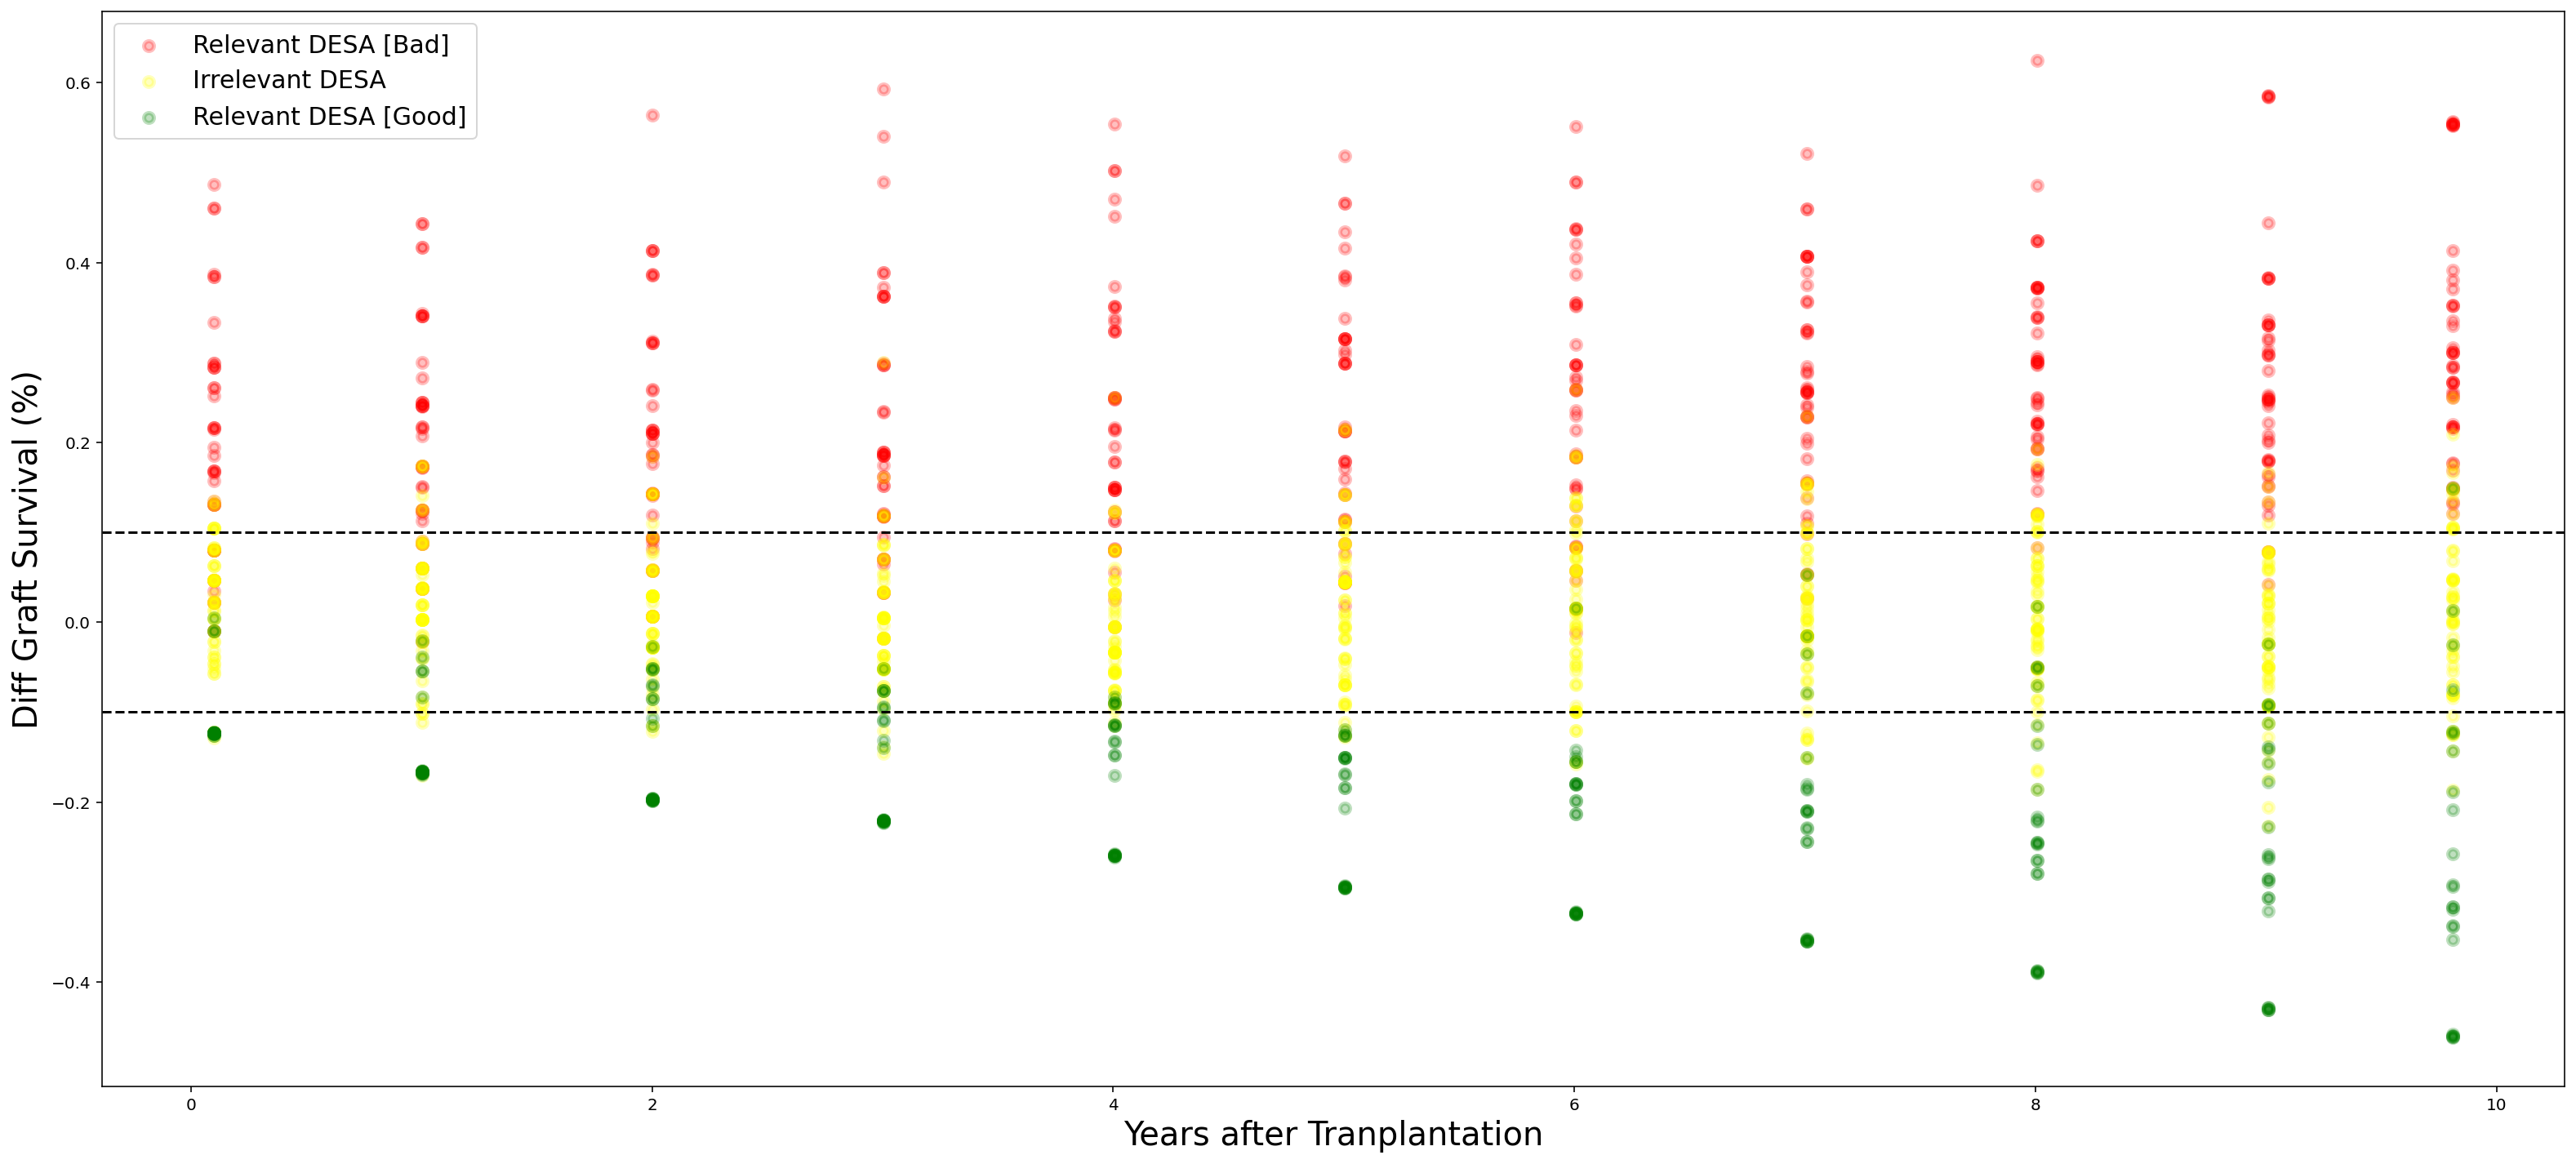

In [7]:
class_I_A = {
    '150AAH', '56R', '62EE', '62QE', '66NH', '76VDT',
    '105S', '73ID', '207S', '245AS', '193AV', '150AH'
            }

class_I_B = {
    '44RMA', '45KE', '62GRN',  '71TD',  '76ED', '80TLR',
    '74Y', '65QIA', '94I', '97V', '158T', '144QL', 
            }
class_II_dq = {'45EV', '96HK', '76ED'}
class_II_drb1 = {'31FY', '37S', '74L', '96HK', '142M'}
class_II_dr134 = {'4Q', '31FH', '32H', '149H'}
class_II_dr5 = {
    '96EV', '108T', '30D', '71A', '70DA', 
    '67F', '30G[DR]', '70DRA', '74A', '6C', 
               }

class_I = { '44RMA', '45KE', '56R', '62EE', '62GRN', '62QE', '65QIA', '66NH', '71TD', '73ID', '74Y', '76ED', '76VDT', '80TLR', '94I', '97V', 
           '105S', '144QL', '150AAH', '150AH', '158T', '193AV', '207S', '245AS' }
class_II_dr = {'4Q', '6C', '30D', '30G[DR]', '31FY', '31FH', '32H', '37S', '67F', '70DA', '70DRA', '71A', '74A', '74L', '96EV', '96HK', '108T', '140TV', '142M', '149H'}
class_II_dq = {'45GV','45EV', '46VY'}

relevant_desa_bad = class_I | class_II_dr | class_II_dq 

relevant_desa_good_old = {'26L[DR]', '28D', '30C', '31I', '37F', '37FL', '37YV[DQ]', '44RT','55PPA' , '57V[DR]', '57V[DQ]', '62LQ', '70QRA', '70QT', '70QA', '71ATD', 
                      '71QS', '73AN', '73G', '73TVS',  '73GQ', '80I', '97S', '97N', '98KN', '104AK', '116I', '120N','125SQ', '125G', '130Q', '147L', '151AHA', 
                      '152A', '152RA', '152RR', '163RW', '173K', '177DT', '180E', '193PL',  '245V', '267QE'}

relevant_desa_good = {
    '30C', '37F', '37YV[DQ]', '55PPA', '62LQ', '71ATD', '71QS', '73AN', '73TVS', '80I', '97S', 
    '130Q', '147L', '152A', '152RA', '152RR', '163RW', '173K', '177DT', '180E', '193PL', '267QE',
    '44RT', '245V',
}

irrelevant_desa = {'65GK', '163LG', '152HA', '107W', '163R', '95V', '57DE', '96Q', '66IF', '98E', '73AS', '87F', '55PP', '133RS', '185I', '166ES', '162GLS', '66KH', 
                    '66KA', '55R', '96QN', '70GT', '96Y', '98Q', '9T', '182N', '51R', '67VG', '74S', '13SE', '77N[DR]', '70QQ', '52PQ', '37YA', '77T[DQ]', '82LR', 
                   '56L', '86A', '71KA', '166DG', '97I', '76EN', '97M', '76ESN', '71TTS', '37YV[DR]', '67VT', '74EL', '52LL', '41T', '81ALR', '76ESI', '30G[B]', '38L', 
                   '71K', '70QK', '66IC', '96H', '71SA', '47F', '17S', '9H',}

desas = [relevant_desa_bad, irrelevant_desa, relevant_desa_good]
confounders = [
    'RecipientAge_NOTR', 'RecipientAge_NOTR*RecipientAge_NOTR', 
    'DonorAge_NOTR', 'DonorAge_NOTR*DonorAge_NOTR', 'IL2rMoAb', 
    'CIPHour_DBD', 'CIPHour_DCD', 
]

plot_scatter_diff(df, desas, confounders, adjust=True)

# Finding relevant DESA using trial & error

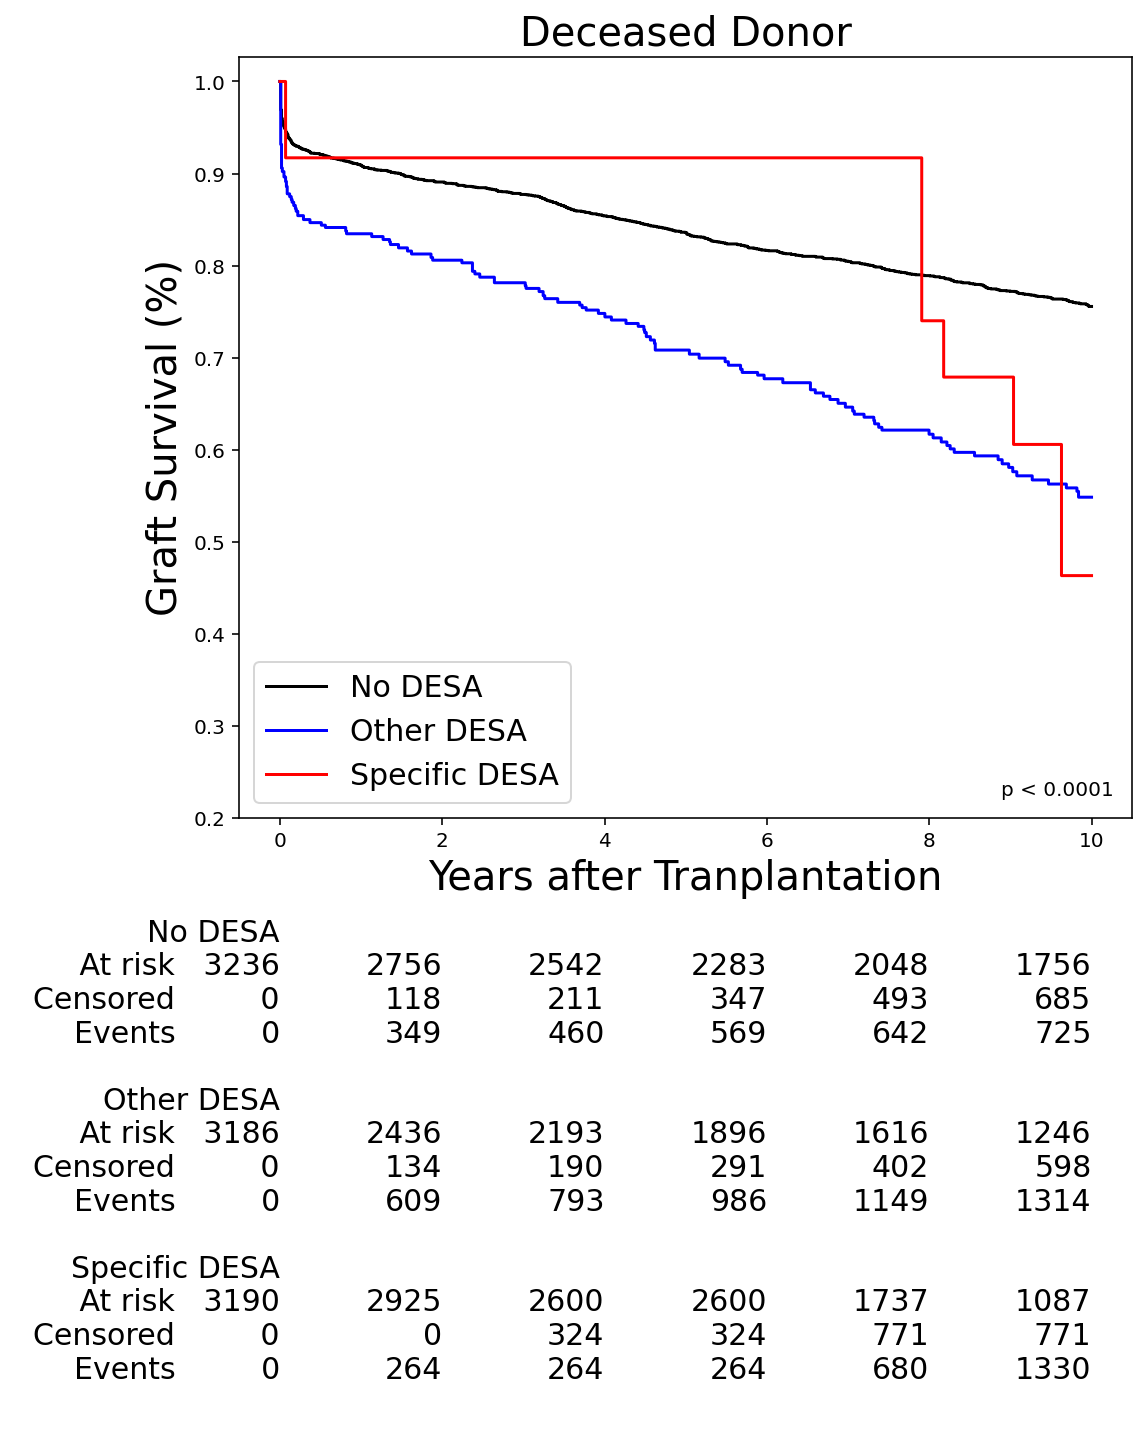

Top curve: 75.56, Middle curve:  54.83, Lower curve: 46.31
10-Year Gap is:  29.24
1-Year Gap is: -8.25


In [19]:
# Not relevant 199V, 152HA, 31I, 65GK, 151AHA, 37FL, 98KN, 107W, 163LG, 163R, 57V[DR], 95V, 70QT, 70QA, 71ATD, 163RW, 57DE, 76ANT, 77NGT, 30H[DQ], 120N, 96Q, 97N, 13FE, 125G, 87Y, 
    # 173K, 66IF, 245V, 98E, 44RT, 152RA, 73AS, 55PPA, 71QS, 193PL, 76VS, 76VRN, 57V[DQ], 87F, 116I, 37YV[DQ], 125SQ, 73TVS, 80I, 30C, 267QE, 37F, 73AN, 152A, 37L, 70QRA, 177DT, 180E
    # 97S, 62LQ, 28D, 147L, 130Q, 73G, 73GQ, 104AK, 26L[DR]

# irrelevant = { '199V', '152HA', '31I', '65GK', '151AHA', '37FL', '98KN', '107W', '163LG', '163R', '57V[DR]', '95V', '70QT', '70QA', '71ATD', '163RW', '57DE', '76ANT', '77NGT',
#               '30H[DQ]', '120N', '96Q', '97N', '13FE', '125G', '87Y', '173K', '66IF', '245V', '98E', '44RT', '152RA', '73AS', '55PPA', '71QS', '193PL', '76VS', '76VRN', '57V[DQ]',
#               '87F', '116I', '37YV[DQ]', '125SQ', '73TVS', '80I', '30C', '267QE', '37F', '73AN', '152A', '37L', '70QRA', '177DT', '180E', '97S', '62LQ', '28D', '147L', '130Q', 
#               '73G', '73GQ', '104AK', '26L[DR]'}
    
# Maybe relevant: 55PP, 133RS, 185I, 144KR, 166ES, 162GLS, 66KH, 66KA, 55R, 96QN, 70GT, 70QA, 96Y, 98Q, 9T, 182N, 44KM, 51R, 67VG, 74S, 13SE, 77N[DR], 70QQ, 52PQ, 37YA, 77T[DQ]
    # 82LR, 56L, 80TA, 86A, 71KA, 114R, 166DG, 97I, 76EN, 97M, 181M, 76ESN, 71TTS, 37YV[DR], 67VT, 74EL, 16Y, 52LL, 41T, 81ALR, 76ESI, 30G[B], 38L, 71K, 70QK, 66IC, 96H, 152RR, 151AHE
    # 184A, 71SA, 47F, 70RE, 70R, 74E, 66EV, 25Q, 98ES, 17S, 80K, 253Q, 9H, 149AH, 67LQ, 71E, 70Q
    
# Relevant 45EV, 48Q, 151AHV, 156QA, 55PPD, 163RG, 151AHV, 127K, 161D, 96EV, 28H, 76ED, 96HK, 11STS, 149H, 108T, 45GV, 37S, 142M, 71A, 76ET, 80TLR, 56R, 30D, 150AAH, 70DA, 31FH, 70DRA, 
    # 45KE, 76VDT, 71TD, 62QE, 4Q, 62GRN, 74L, 30G[DR], 73ID, 67F, 66NH, 66NM, 74Y, 140TV, 46VY, 62EE, 158T, 150AH, 193AV, 30H[DR], 97V, 94I, 70DR, 6C, 65QIA, 207S, 105S, 32H
    
# Early Relevant: 9F[DQ], 45EV, 76ET, 80TLR, 245AS
# Late Relevant: 62GE, 96EV, 70QT, 57DE, 44KM, 120N, 13FE, 80TA, 71KA, 114R, 166DG, 181M, 74L, 66NM, 66IC, 151AHE, 30H[DR], 70RE, 74E, 31FY, 66EV

# Ourgalaxy teamn {'76ED', '45EV', '96EV', '149H', '96HK'} , 11STS, 108T, 45GV, 37S, 142M, 71A, 80TLR, 56R, 30D, 150AAH, 70DA, 31FH, 70DRA, 45KE, 76VDT, 71TD, 62QE, 4Q, 44RMA, 62GRN, 
# 74L, 30G[DR], 73ID, 67F, 66NH, 74Y, 74A, 140TV, 46VY, 62EE, 158T, 150AH, 245AS, 193AV, 144QL, 97V, 94I, 31FY, 6C, 65QIA, 207S, 105S, 32H

# '6C', '207S', '30G[DR]', '31FY', '32H', '44RMA', '45EV', '45GV', '45KE', '46VY', '94I', '96EV', '97V', '96HK', '11STS', '108T', '105S', '37S', '71A', 
#                              '80TLR', '56R', '30D', '150AAH', '31FH', '70DA', '70DRA','71TD', '74A', '74L', '74Y', '76VDT', '76ED',  '73ID', '62QE', '62EE', '62GRN', 
#                              '65QIA', '66NH', '67F', '4Q', '140TV', '142M', '144QL', '149H', '150AH', '158T', '158T', '193AV', '245AS'
# ALl relevant

class_I = { '44RMA', '45KE', '56R', '62EE', '62GRN', '62QE', '65QIA', '66NH', '71TD', '73ID', '74Y', '76ED', '76VDT', '80TLR', '94I', '97V', 
           '105S', '144QL', '150AAH', '150AH', '158T', '193AV', '207S', '245AS' }
class_II_dr = {'4Q', '6C', '30D', '30G[DR]', '31FY', '31FH', '32H', '37S', '67F', '70DA', '70DRA', '71A', '74A', '74L', '96EV', '96HK', '108T', '140TV', '142M', '149H'}
class_II_dq = {'45GV','45EV', '46VY'}

good_epitopes = {
    '30C', '37F', '37YV[DQ]', '55PPA', '62LQ', '71ATD', '71QS', '73AN', '73TVS', '80I', '97S', 
    '130Q', '147L', '152A', '152RA', '152RR', '163RW', '173K', '177DT', '180E', '193PL', '267QE',
    '44RT', '245V',
}

labels = ['No DESA', 'Other DESA', 'Specific DESA']
# kmfs = kaplan_meier_curves(df, desa_spec= class_I | class_II_dr | class_II_dq, labels=labels)
confounders = [
    'RecipientAge_NOTR', 'RecipientAge_NOTR*RecipientAge_NOTR', 
    'DonorAge_NOTR', 'DonorAge_NOTR*DonorAge_NOTR', 'IL2rMoAb', 
    'CIPHour_DBD', 'CIPHour_DCD', 
]

treatments = ['No_DESA', 'Other_DESA', 'Specific_DESA']
ep = {'120N'}
# ep = good_epitopes
df_tret_group = create_treatment_grups(df, ep)
df_weight = find_ipw(df_tret_group, confounders, treatments, verbose=False)
# kmfs = kaplan_meier_curves(df_weight, desa_spec=ep, labels=labels, adjust=False)
# plot_kaplan_meier_curve(kmfs)

kmfs, p_value = kaplan_meier_curves(df_weight, desa_spec=ep, donor_type='Deceased', labels=labels, adjust=True)
plot_kaplan_meier_curve(kmfs, p_value)

# Inverse Probability Weighting

As implied by its name, inverse probability weighting literally refers to weighting the outcome measures by the inverse of the probability of the individual with a given set of covariates being assigned to their treatment (note that this doesn’t depend on whether or not the individual was in fact assigned to treatment). This quantity is known as the propensity score and is denoted by

$$p(x)=P(T=1|X=x)$$

In our case we have to change the treatment group to transplants having DSA/DESA group. Inverse probability weighting literally refers to weighting the outcome measures by the inverse of the probability of the Transplants with a given set of covariates being assigned to the having DSA group (note that this doesn’t depend on whether or not the Transplant actually has DSA/DESA). This quantity is known as the propensity score and is denoted by

$$p(x)=P(Tx\, \in DSA/DESA|X=x)$$


# DESA Relevance
## Bad DESA
### Deceased Donor [Inference Set]

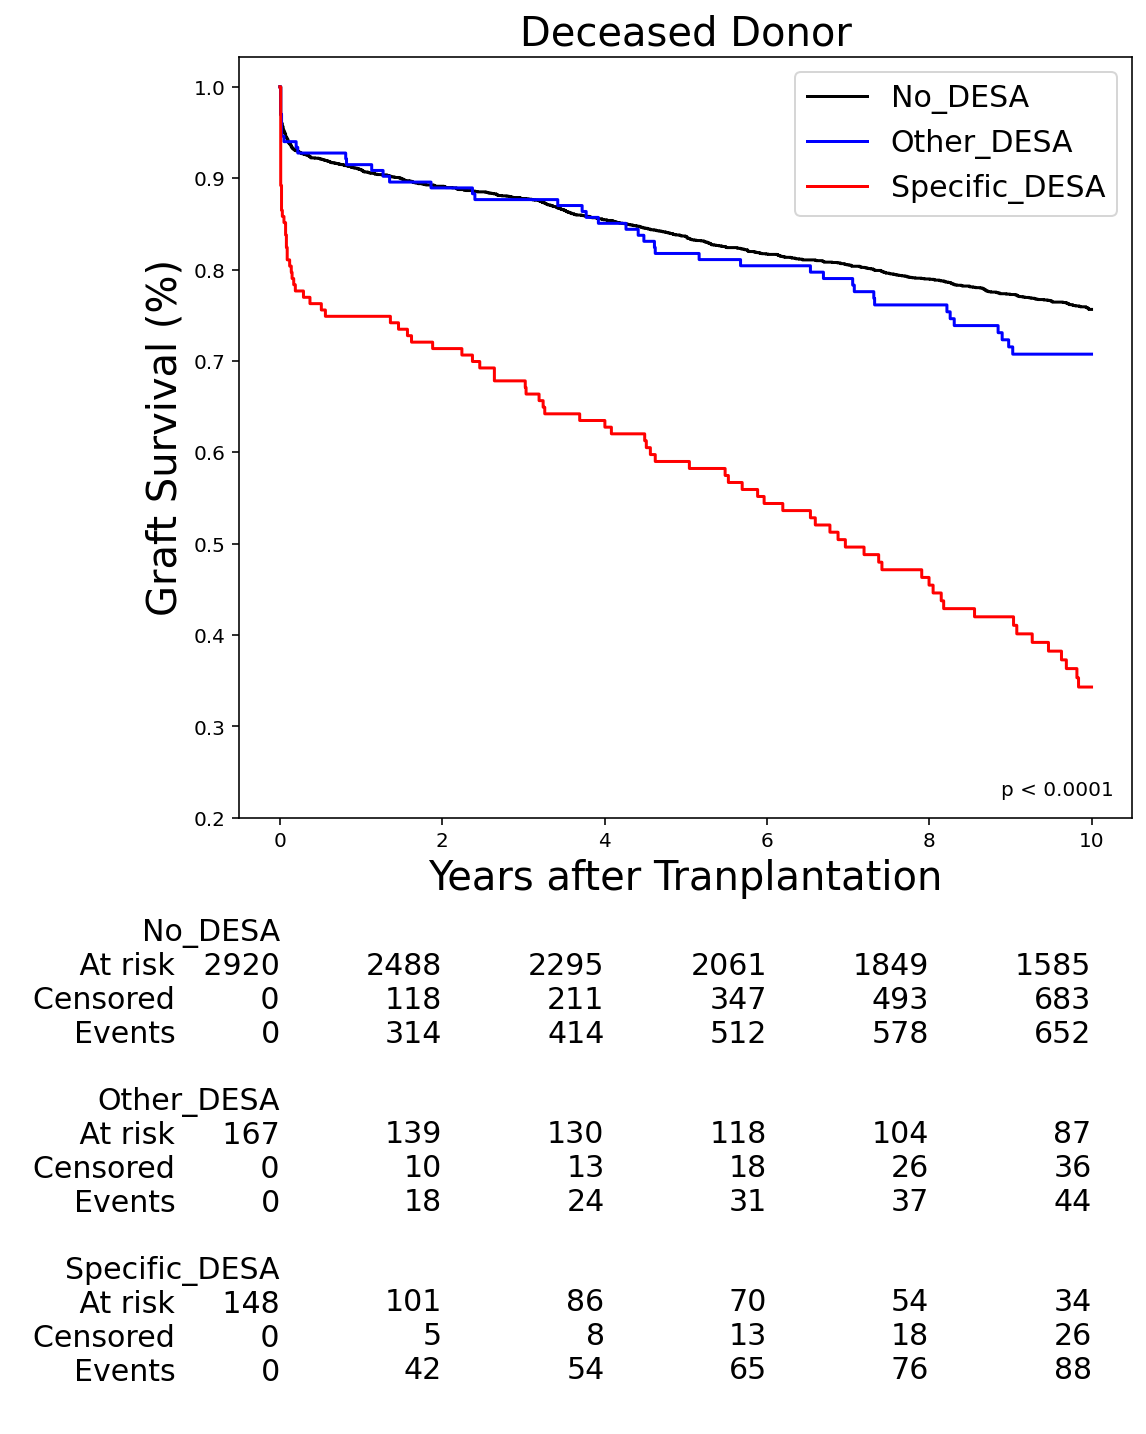

Top curve: 75.64, Middle curve:  70.74, Lower curve: 34.31
10-Year Gap is:  41.33
1-Year Gap is:  16.60


In [18]:
from src.constants import *

confounders = [
    'RecipientAge_NOTR', 'RecipientAge_NOTR*RecipientAge_NOTR', 
    'DonorAge_NOTR', 'DonorAge_NOTR*DonorAge_NOTR', 'IL2rMoAb', 
    'CIPHour_DBD', 'CIPHour_DCD', 
]

treatments = ['No_DESA', 'Other_DESA', 'Specific_DESA']

class_I = { '44RMA', '45KE', '56R', '62EE', '62GRN', '62QE', '65QIA', '66NH', '71TD', '73ID', '74Y', '76ED', '76VDT', '80TLR', '94I', '97V', 
           '105S', '144QL', '150AAH', '150AH', '158T', '193AV', '207S', '245AS' }
class_II_dr = {'4Q', '6C', '30D', '30G[DR]', '31FY', '31FH', '32H', '37S', '67F', '70DA', '70DRA', '71A', '74A', '74L', '96EV', '96HK', '108T', '140TV', '142M', '149H'}
class_II_dq = {'45GV','45EV', '46VY'}

RELEVANT_DESA_BAD = class_I | class_II_dr | class_II_dq 

df_treat_group = create_treatment_grups(df, RELEVANT_DESA_BAD)
df_weight = find_ipw(df_treat_group, confounders, treatments, verbose=False)

kmfs, p_value = kaplan_meier_curves(df_weight, desa_spec=RELEVANT_DESA_BAD, labels=treatments, adjust=False)
plot_kaplan_meier_curve(kmfs, p_value)

# # kmfs = kaplan_meier_curves(df_weight, desa_spec=RELEVANT_DESA_BAD, labels=treatments,  adjust=True)
# plot_kaplan_meier_curve(kmfs, p_value)

### Living Donor [Test Set]

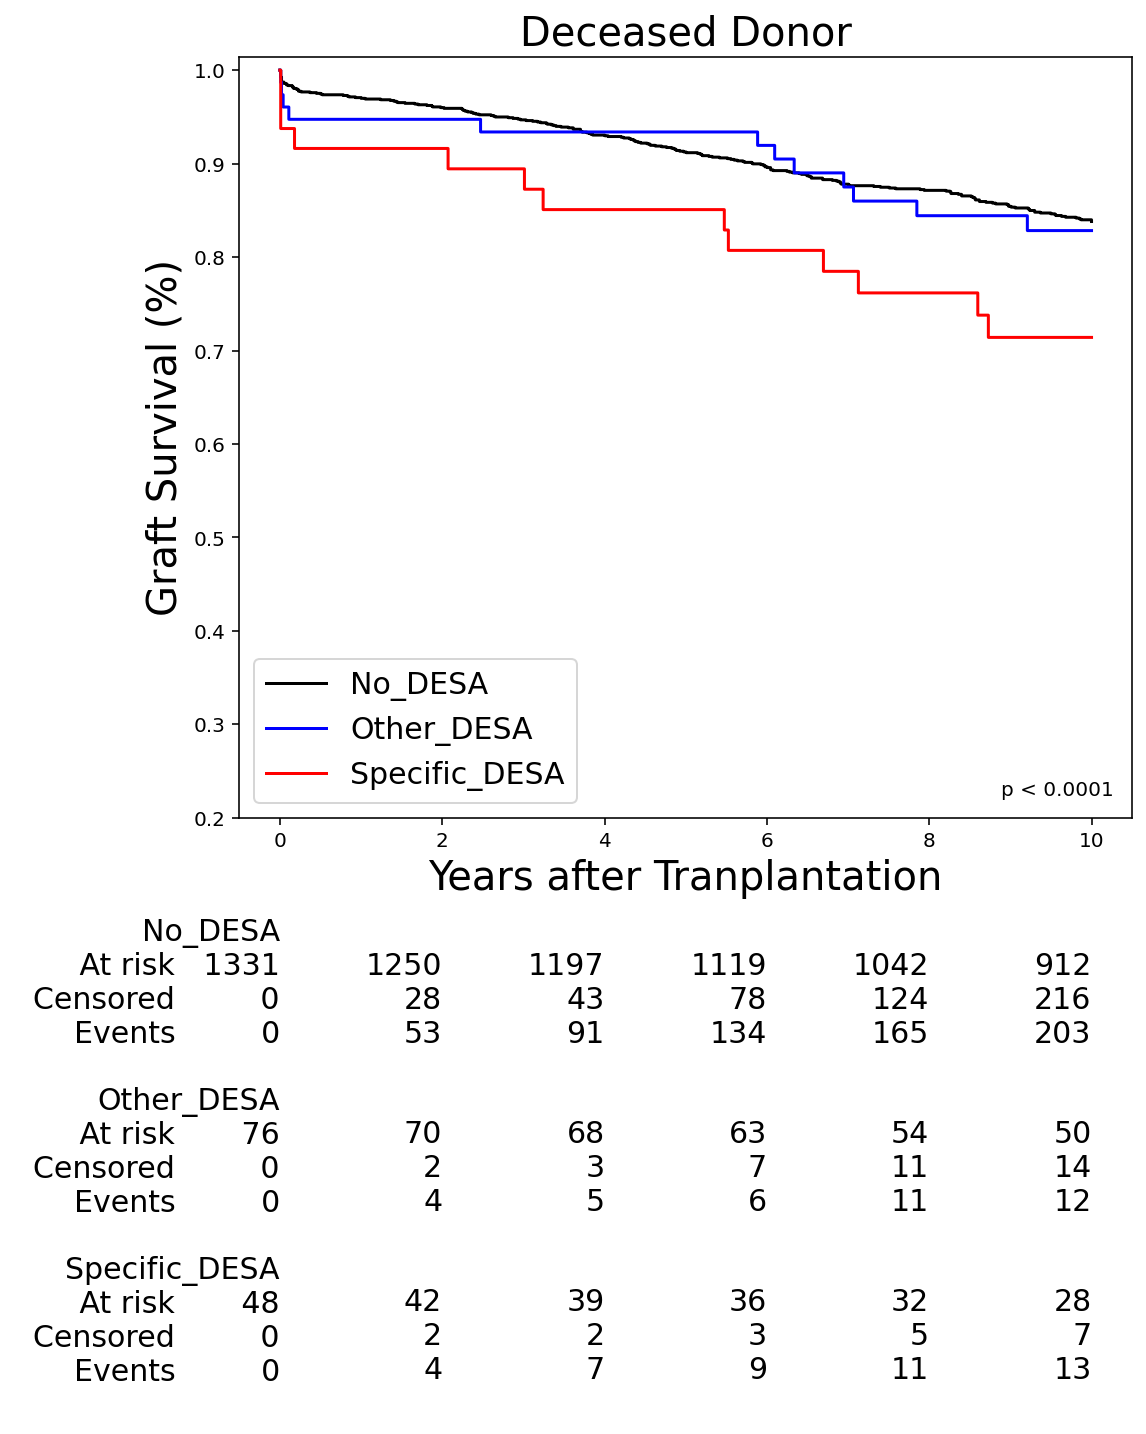

Top curve: 83.80, Middle curve:  82.83, Lower curve: 71.40
10-Year Gap is:  12.40
1-Year Gap is:  3.12


In [20]:
treatments = ['No_DESA', 'Other_DESA', 'Specific_DESA']

class_I = { '44RMA', '45KE', '56R', '62EE', '62GRN', '62QE', '65QIA', '66NH', '71TD', '73ID', '74Y', '76ED', '76VDT', '80TLR', '94I', '97V', 
           '105S', '144QL', '150AAH', '150AH', '158T', '193AV', '207S', '245AS' }
class_II_dr = {'4Q', '6C', '30D', '30G[DR]', '31FY', '31FH', '32H', '37S', '67F', '70DA', '70DRA', '71A', '74A', '74L', '96EV', '96HK', '108T', '140TV', '142M', '149H'}
class_II_dq = {'45GV','45EV', '46VY'}

relevant_desa = class_I | class_II_dr | class_II_dq 

df_treat_group = create_treatment_grups(df, relevant_desa)
df_weight = find_ipw(df_treat_group, confounders, treatments, verbose=False)
kmfs, p_value = kaplan_meier_curves(
    df_weight,
    desa_spec=relevant_desa,
    donor_type='Living',
    labels=treatments,
    adjust=False)
plot_kaplan_meier_curve(kmfs, p_value)

## Good DESA

### Deceased Donor [Inference Set]

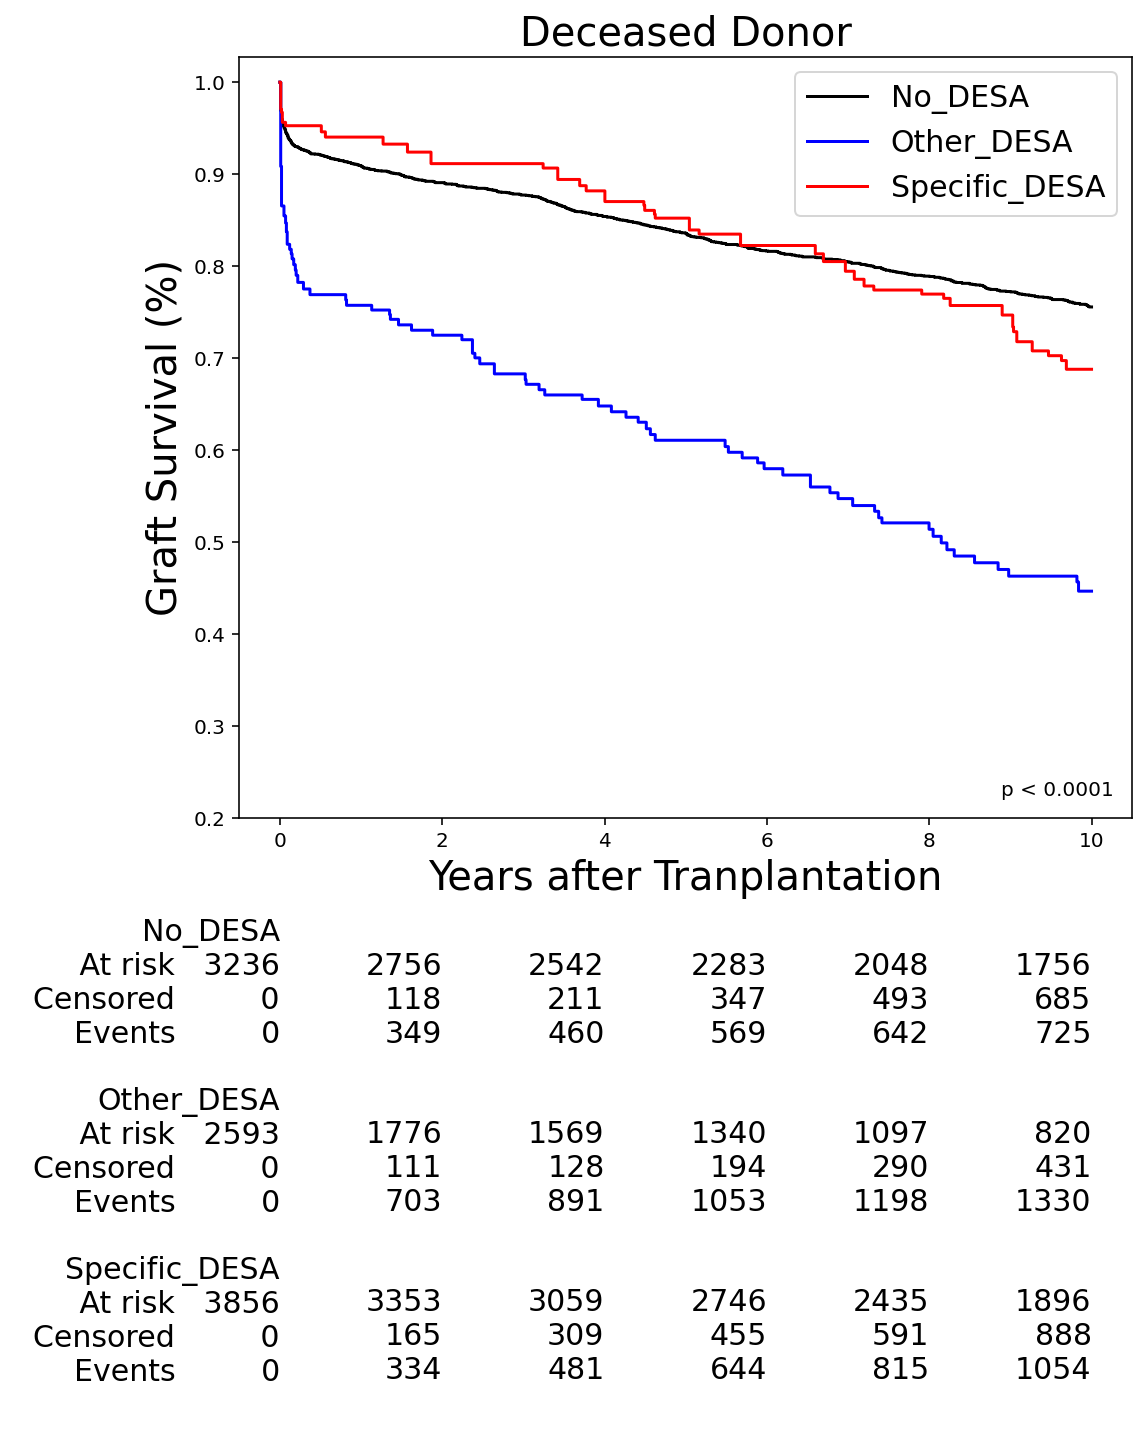

Top curve: 75.56, Middle curve:  44.65, Lower curve: 68.78
10-Year Gap is:  6.78
1-Year Gap is: -18.30


In [21]:
# good_epitopes = {
#     '30C', '37F', '37YV[DQ]', '55PPA', '62LQ', '71ATD', '71QS', '73AN', '73TVS', '80I', '97S', 
#     '130Q', '147L', '152A', '152RA', '152RR', '163RW', '173K', '177DT', '180E', '193PL', '267QE',
#     '44RT', '245V',
# }

df_treat_group = create_treatment_grups(df, good_epitopes)

confounders = [
    'RecipientAge_NOTR', 'RecipientAge_NOTR*RecipientAge_NOTR', 
    'DonorAge_NOTR', 'DonorAge_NOTR*DonorAge_NOTR', 'IL2rMoAb', 
    'CIPHour_DBD', 'CIPHour_DCD', 
]

treatments = ['No_DESA', 'Other_DESA', 'Specific_DESA']
df_weight = find_ipw(df_treat_group, confounders, treatments, verbose=False)

# kmfs, p_value = kaplan_meier_curves(df, desa_spec=good_epitopes, labels=treatments, adjust=False)
# plot_kaplan_meier_curve(kmfs, p_value)
good_epitopes = RELEVANT_DESA_GOOD_OLD
kmfs, p_value = kaplan_meier_curves(df_weight, desa_spec=good_epitopes, labels=treatments, adjust=True)
plot_kaplan_meier_curve(kmfs, p_value)

### Living Donor [Test Set]

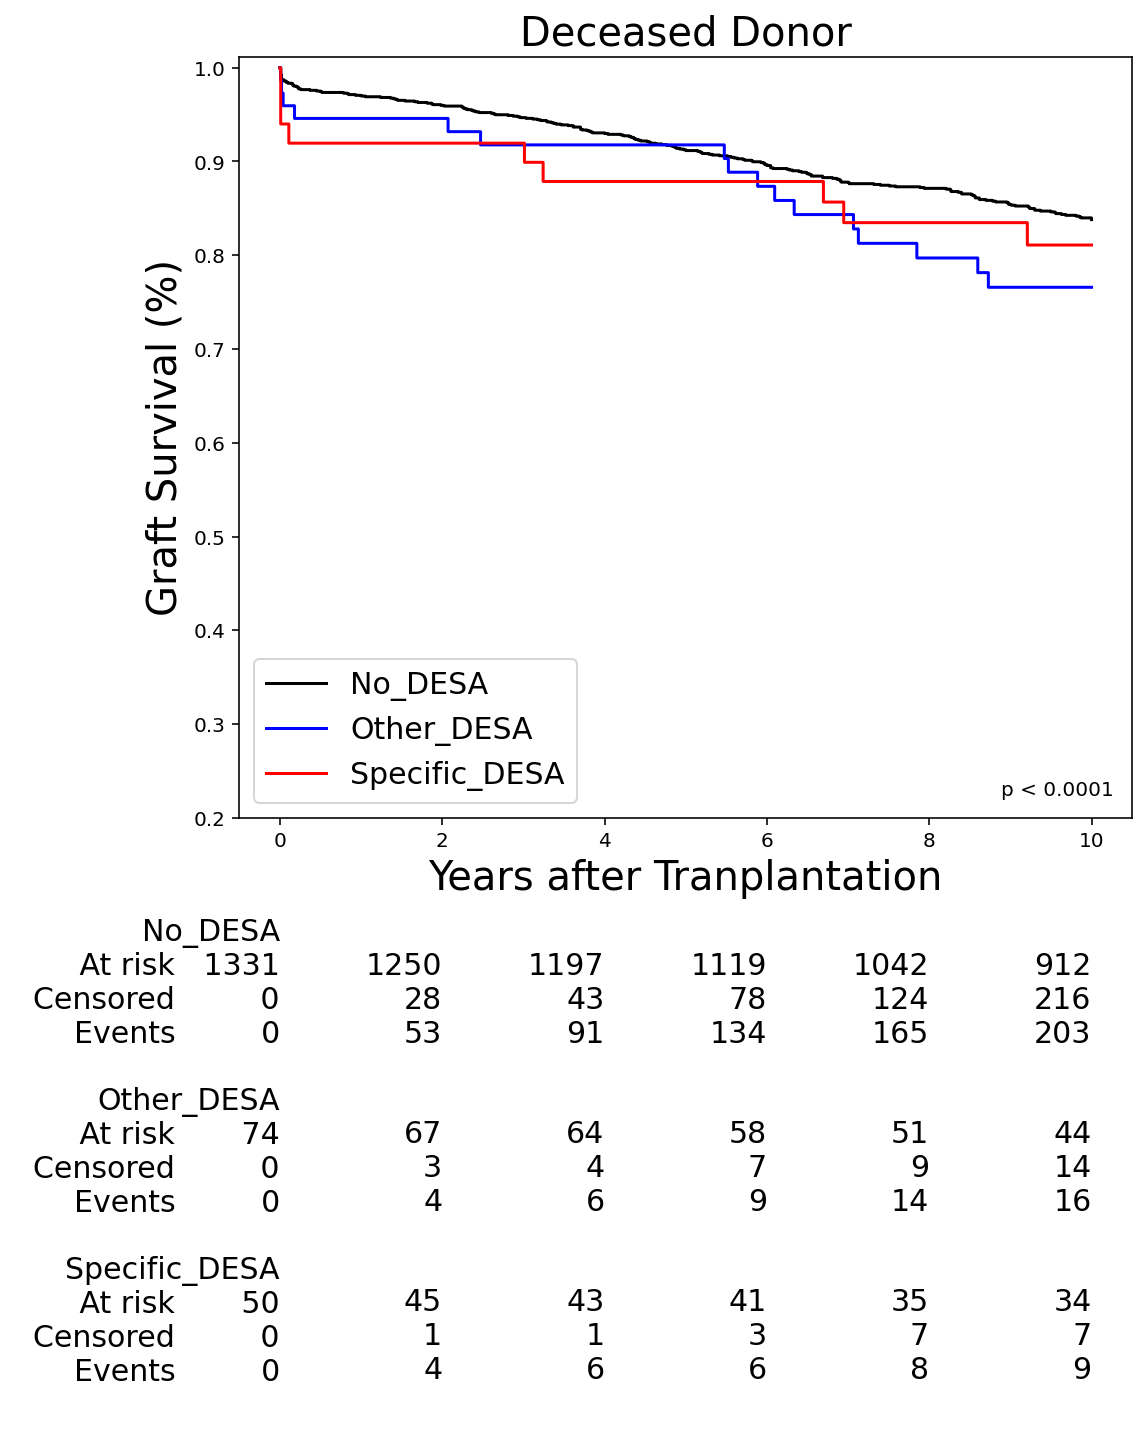

Top curve: 83.80, Middle curve:  76.58, Lower curve: 81.09
10-Year Gap is:  2.71
1-Year Gap is:  2.64


In [22]:
treatments = ['No_DESA', 'Other_DESA', 'Specific_DESA']

RELEVANT_DESA_GOOD_OLD = {
    '26L[DR]', '28D', '30C', '31I', '37F', '37FL', '37YV[DQ]', '44RT','55PPA' , '57V[DR]', '57V[DQ]', '62LQ', '70QRA', '70QT',
    '70QA', '71ATD', '71QS', '73AN', '73G', '73TVS',  '73GQ', '80I', '97S', '97N', '98KN', '104AK', '116I', '120N','125SQ', '125G', 
    '130Q', '147L', '151AHA', '152A', '152RA', '152RR', '163RW', '173K', '177DT', '180E', '193PL',  '245V', '267QE' 
}

good_epitopes = RELEVANT_DESA_GOOD_OLD

df_treat_group = create_treatment_grups(df, good_epitopes)
kmfs, p_value = kaplan_meier_curves(df_treat_group, desa_spec=good_epitopes, donor_type='Living', labels=treatments,  adjust=False)
plot_kaplan_meier_curve(kmfs, p_value)

## Quantity of DESA

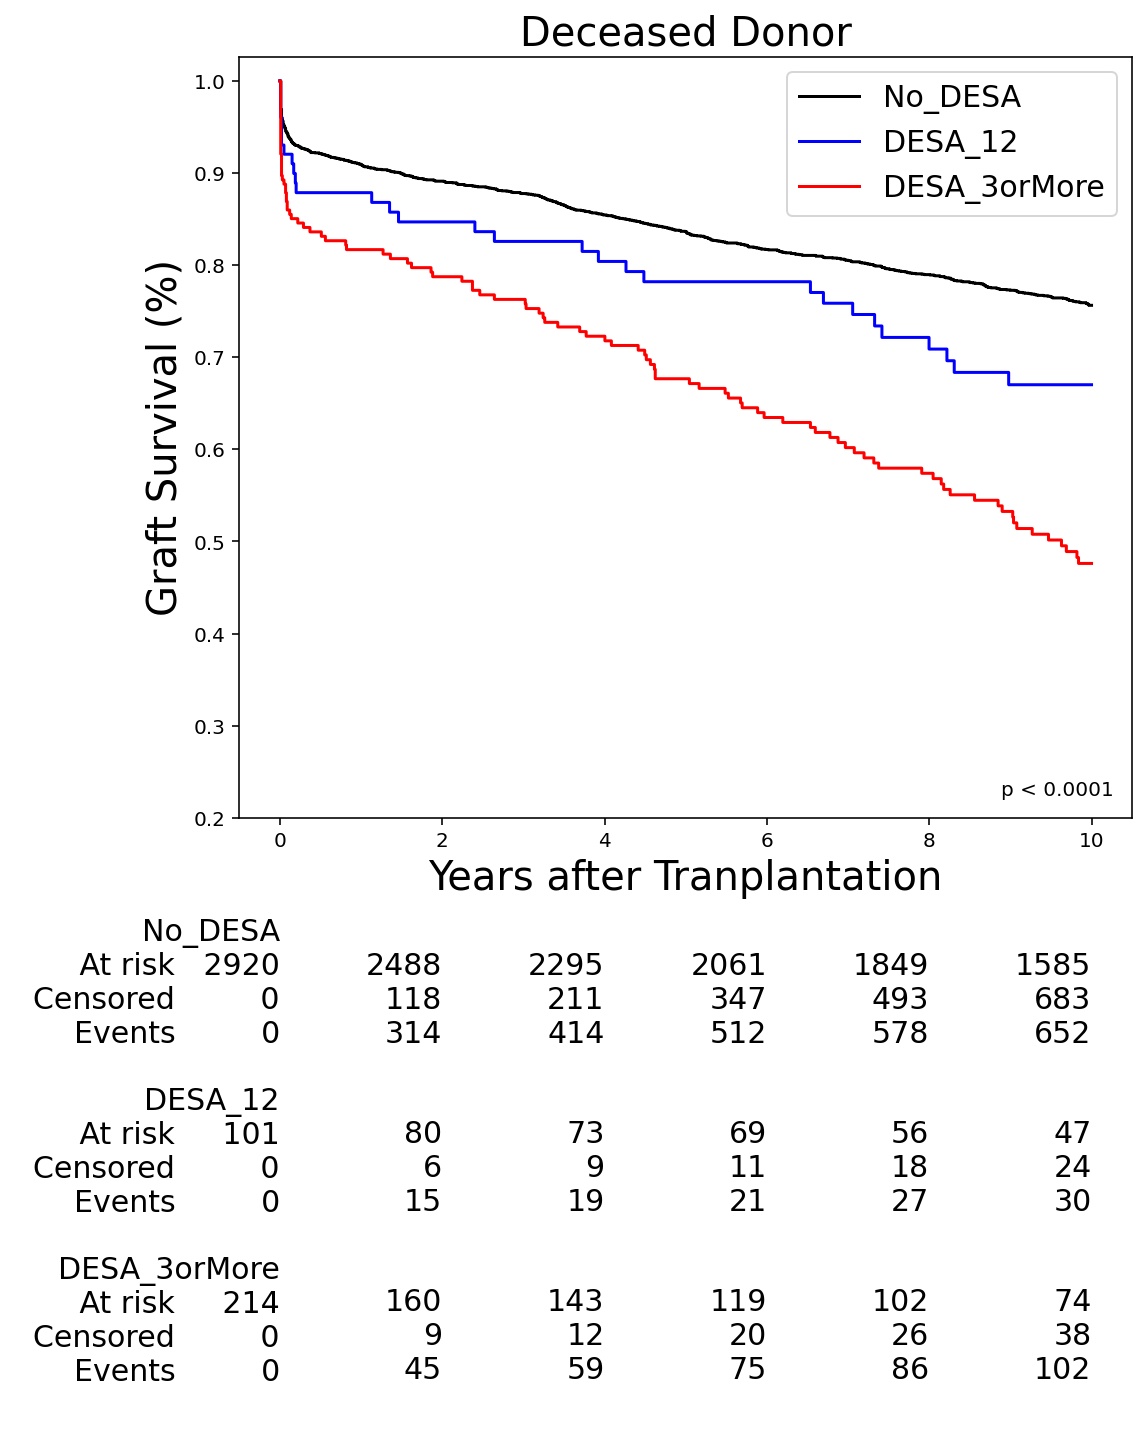

Top curve: 75.64, Middle curve:  67.01, Lower curve: 47.62
10-Year Gap is:  28.02
1-Year Gap is:  6.19


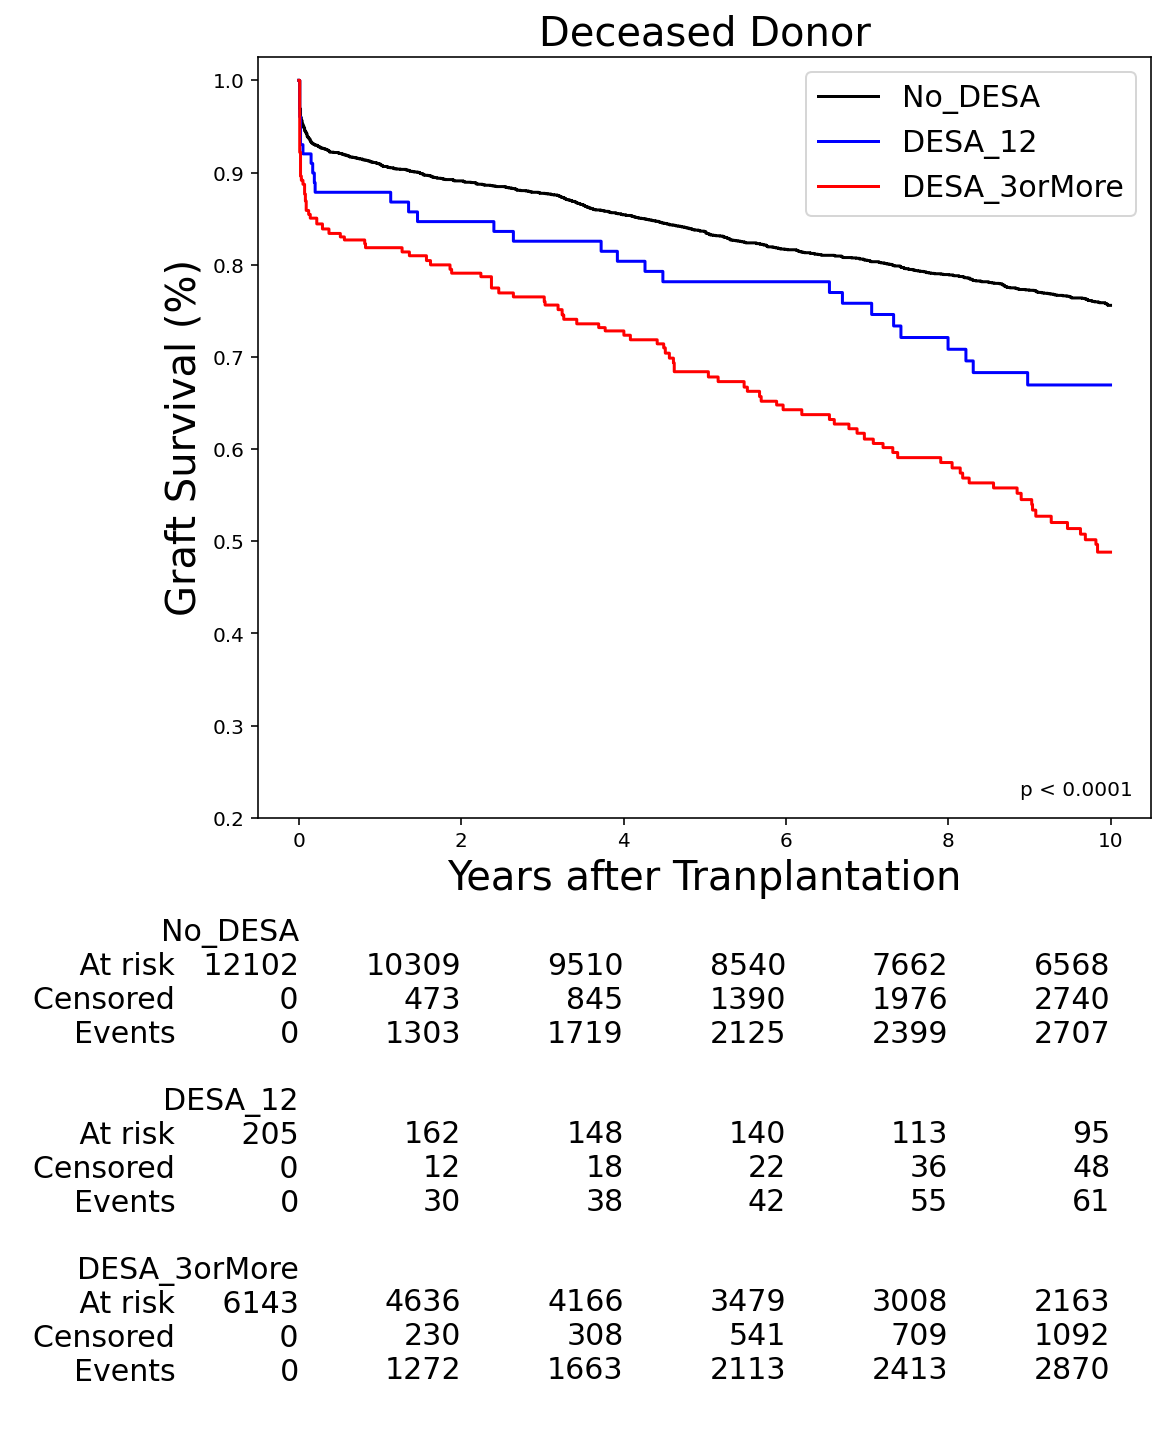

Top curve: 75.59, Middle curve:  66.95, Lower curve: 48.82
10-Year Gap is:  26.77
1-Year Gap is:  6.01


In [53]:
confounders = [
    'RecipientAge_NOTR', 'RecipientAge_NOTR*RecipientAge_NOTR', 
    'DonorAge_NOTR', 'DonorAge_NOTR*DonorAge_NOTR', 'IL2rMoAb', 
    'CIPHour_DBD', 'CIPHour_DCD', 
]

treatments = ['No_DESA', 'DESA_12', 'DESA_3orMore']
df_treat_group = create_treatment_grups(df)
df_weight = find_ipw(df_treat_group, confounders, treatments, verbose=False)

kmfs, p_value = kaplan_meier_curves(df_weight, labels=treatments, adjust=False)
plot_kaplan_meier_curve(kmfs, p_value)

kmfs, p_value = kaplan_meier_curves(df_weight, labels=treatments, adjust=True)
plot_kaplan_meier_curve(kmfs, p_value)

# Combining the figures for all donors Bad & Good

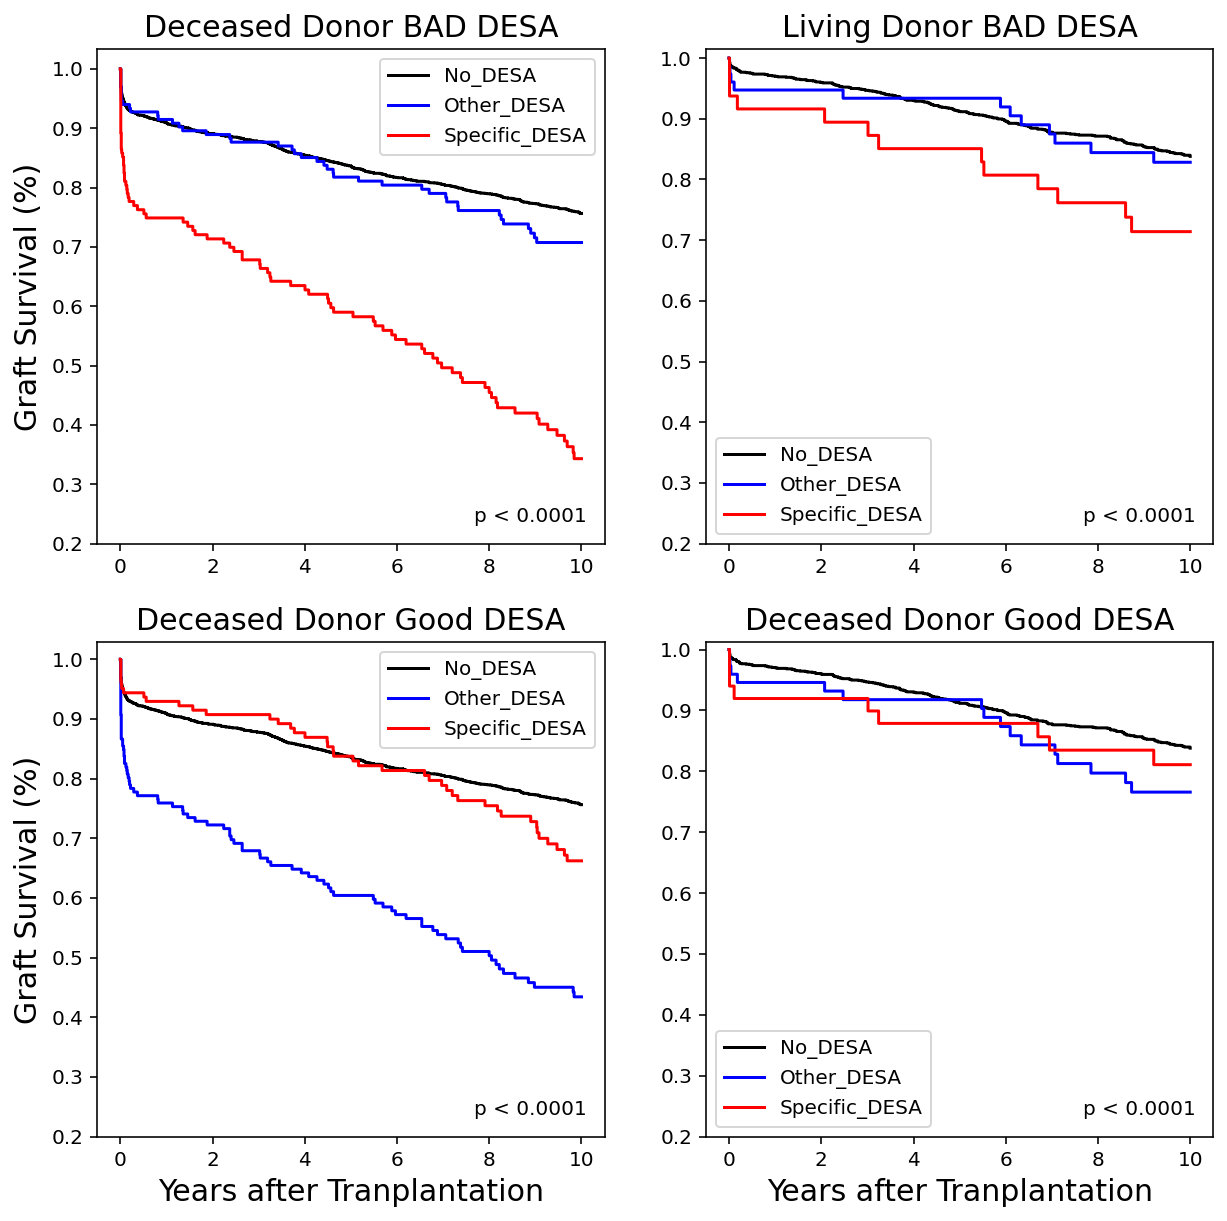

In [87]:
import matplotlib.pyplot as plt
treatments = ['No_DESA', 'Other_DESA', 'Specific_DESA']

fig, ax = plt.subplots(2, 2, figsize=(10, 10))

# BAD DESA
df_treat_group_bad = create_treatment_grups(df, RELEVANT_DESA_BAD)
kmfs, p_value = kaplan_meier_curves(df_treat_group_bad, desa_spec=RELEVANT_DESA_BAD, donor_type='Deceased', labels=treatments,  adjust=False)
plot_kaplan_meier_curve(kmfs, p_value, add_counts=False, ax=ax[0, 0], title='Deceased Donor BAD DESA', xlabel=None)
kmfs, p_value = kaplan_meier_curves(df_treat_group, desa_spec=RELEVANT_DESA_BAD, donor_type='Living', labels=treatments,  adjust=False)
plot_kaplan_meier_curve(kmfs, p_value, add_counts=False, ax=ax[0, 1], title='Living Donor BAD DESA', xlabel=None, ylabel=None)

# GOOD DESA
df_treat_group_good = create_treatment_grups(df, RELEVANT_DESA_GOOD_OLD)
kmfs, p_value = kaplan_meier_curves(df_treat_group_good, desa_spec=RELEVANT_DESA_GOOD_OLD, donor_type='Deceased', labels=treatments,  adjust=False)
plot_kaplan_meier_curve(kmfs, p_value, add_counts=False, ax=ax[1, 0], title='Deceased Donor Good DESA')
kmfs, p_value = kaplan_meier_curves(df_treat_group_good, desa_spec=RELEVANT_DESA_GOOD_OLD, donor_type='Living', labels=treatments,  adjust=False)
plot_kaplan_meier_curve(kmfs, p_value, add_counts=False, ax=ax[1, 1], title='Deceased Donor Good DESA', ylabel=None)
